In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [6]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
test_csv = PATH / 'ISIC/test_isic17.csv'

test_mel_p = PATH / 'ISIC/test_mel_17.csv'
test_ker_p = PATH / 'ISIC/test_ker_17.csv'
test_all_p = PATH / 'ISIC/test_all_17.csv'
test_raw_p = PATH / 'ISIC/test_raw_17.csv'

train_skp = PATH / 'train_multi_sk.csv'
train_melp = PATH / 'train_multi_mel.csv'
train_all = PATH / 'train_multi.csv'
train_raw = PATH / 'train_multi_raw.csv'

%ls $PATH

dermofit/                        train_multi_no_ia_nervi.csv*
ISIC/                            train_multi_raw.csv*
isic18_p3_test_data*             train_multi_raw_half_ia_nervi.csv*
isic_archive/                    train_multi_raw_no_ia_nervi.csv*
models/                          train_multi_sk.csv*
ph2dataset/                      train_mutli_SK_half.csv*
test_isic17_dermofitLabels.csv*  train_seg_classes_multi.csv*
tmp/                             train_seg_isic17_dermo.csv*
train_dermofit_isic17.csv*       train_seg_keratosis_multi.csv*
train_Mel_seg_isic17_dermo.csv*  train_seg_melanoma_multi.csv*
train_multi.csv*                 train_SK_seg_isic17_dermo.csv*
train_multi_half_ia_nervi.csv*   train_test_Mel_seg_isic17_dermo.csv*
train_multi_mel.csv*             val_isic17.csv*
train_multi_Mel_half.csv*


## Setup Trainer

In [21]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=resnet34
# image size
sz=224
bs=64
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification_lesion_seg/'
train_csv = PATH / 'train_classes_multi_halfn.csv'
# val_idx = list(range(5615 - 150, 5615))
val_idx = None
# len(train_df) = 5615
test_csv = PATH / 'ISIC/test_classes_multi_halfn.csv'
w_name = arch.__name__ + ''

augs = transforms_top_down + [RandomZoom(zoom_max=2, zoom_min=0)]

trainer = ClassifierTrainer(PATH, arch, sz, bs, train_csv, test_folder=test_folder, val_idx=val_idx, sn=w_name,
                  num_workers=1, test_csv=test_csv, aug_tfms=augs)

Saving model as "resnet34"
-> Train set value counts
nevus        4164
melanoma     1221
keratosis     562
Name: classes, dtype: int64
Test set value counts
nevus        393
melanoma     117
keratosis     90
Name: classes, dtype: int64
Dataset has: ['keratosis', 'melanoma', 'nevus'] classes


In [ ]:
for i in range(min(len(data.classes),10)): sample_ims(PATH, i, data, numimgs=3, figsize=(10,5))

In [87]:
augs = transforms_top_down + [RandomZoom(zoom_max=1.1, zoom_min=-0.5), RandomBlur()]
# augs = transforms_top_down + [RandomScale(sz=300, max_zoom=2)]
tfms = tfms_from_model(resnet34, 300, aug_tfms=augs)

def get_augs():
    data = ImageClassifierData.from_csv(PATH, '', train_csv, bs=2, tfms=tfms, num_workers=1, suffix='')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

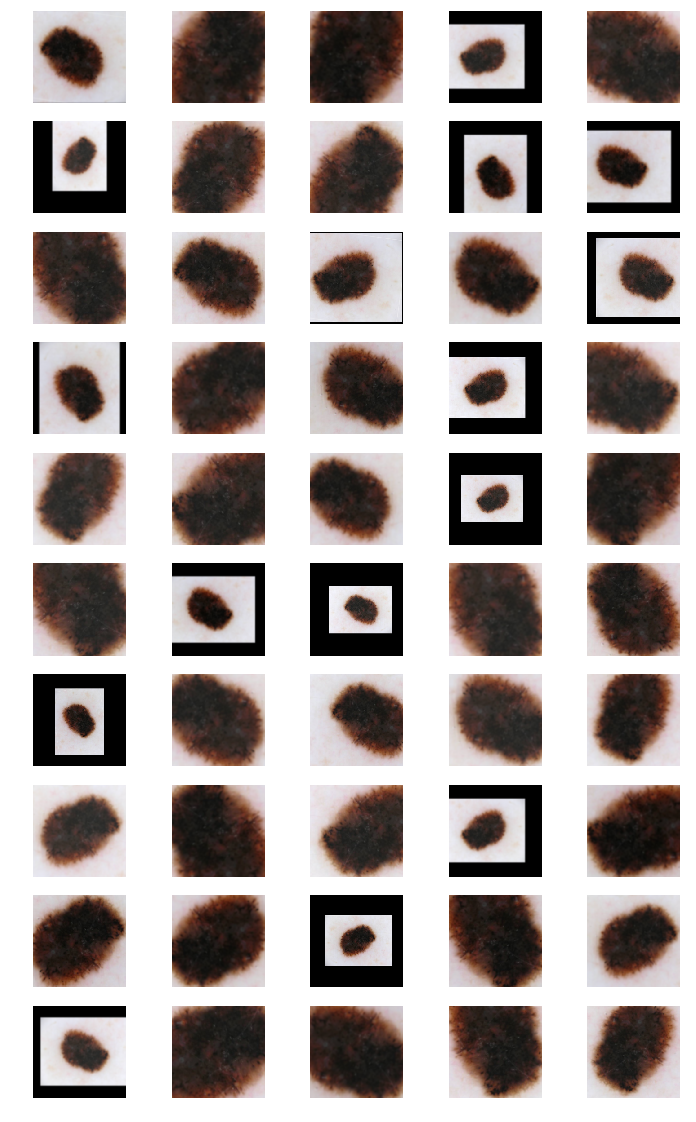

In [88]:
ims = np.stack([get_augs() for i in range(50)])
# print([i.shape for i in ims])
plots(ims, rows=10, figsize=(12, 20))

 93%|█████████▎| 42/45 [01:30<00:06,  2.16s/it, loss=2.4] 

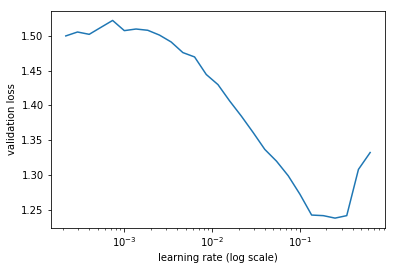

In [9]:
trainer.lr_find()

In [8]:
trainer.check_test_names()

In [10]:
trainer.set_lr(1e-2)
trainer.init_fit(w_name + '_1')

epoch      trn_loss   val_loss   accuracy                  
    0      0.882654   0.61029    0.771709  
    1      0.740615   0.585696   0.780112                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.630645   0.57052    0.791317  
    1      0.62901    0.574561   0.787115                  
Saved weights as "resnet34_1"


In [11]:
trainer.test_eval()

Loading ys from csv; shape (600,); vals [0 1 2]; in folder "ISIC/ISIC-2017_Test_v2_Data_Classification_lesion_seg/"
Accuracy = 0.69
Confusion Matrix:
[[ 50  15  25]
 [ 11  50  56]
 [ 17  64 312]]
AUC for class 0, id keratosis = 0.89
AUC for class 1, id melanoma = 0.75
AUC for class 2, id nevus = 0.79


[array([1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2,
        0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2,
        2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2,
        2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 1,
        2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 0,
        2, 1, 1, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0, 2, 1, 2, 2,
        2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2,
        2,

In [ ]:
trainer.inter_fit(w_name + '_2')

  0%|          | 0/86 [00:00<?, ?it/s]

In [ ]:
trainer.final_fit(w_name + '_3')
self.test_eval()

In [ ]:
dd